<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_3%EC%9E%A5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. 분류



## 3.1 MNIST

#### 데이터셋 내려받기

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

mnist=fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)



> 이미지 = 70000개, 각 이미지에는 784개(28*28 픽셀)의 특성 존재



* 샘플의 특성 벡터 추출해서 28*28 배열로 크기 변경
* matplotlib imshow() 함수 사용해서 그리기

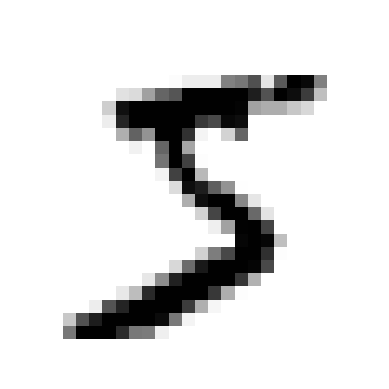

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'



> 레이블이 문자열이므로 y를 정수로 변환


In [5]:
y = y.astype(np.uint8)

In [6]:
y[0]

5

#### 데이터셋 나누기

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [8]:
y_train_5 = (y_train == 5) #5는 True, 다른 숫자 모두 False
y_test_5 = (y_test == 5)

확률적 경사 하강법(SGD) 분류기를 훈련
* 큰 데이터셋을 효율적으로 처리
* 한 번에 하나씩 훈련 샘플을 독립적으로 처리

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

> 이 모델을 활용해 숫자 5 이미지 감지




In [10]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

* 교차 검증 구현


```

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
```



cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SDGClassifier 모델 평가
* k-겹 교차 검증: 훈련 세트를 k개의 폴드로 나누고 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

교차 검증 결과 95% 이상의 정확도 나옴
* 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 만들기

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

> 불균형한 데이터셋을 다룰 때, 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유

### 3.3.2 오차 행렬
* 분류기 성능 평가에 더 좋은 방법: 오차 행렬 조사

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`confusion_matrix()` 함수로 오차행렬 생성
* 타겟 클래스: y_train_5
* 예측 클래스: y_train_pred

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬
```
TN | FP
---|---
FN | TP
```

* TN: 참 음성 개수
* FP: 거짓 양성 개수
* FN: 거짓 음성 개수
* TP: 참 양성 개수

In [16]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

* 정밀도 = TP/(TP+FP)
* 재현율 = TP/(TP+FN)

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)#정밀도

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)#재현율

0.6511713705958311

#### F1 스코어

f1_score(): 정밀도와 재현율의 조화평균
F1=TP/[TP+{(FN+FP)/2}]

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프
* 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지인 현상

 decision_function(): 각 샘플의 점수 얻을 수 있음

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

> 임곗값이 0이므로 True 반환

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

> 임곗값 높였더니 재현율 줄어듦

#### 적절한 임곗값 정하는법
* cross_val_predict()함수 사용해 훈련세트에 있는 모든 샘플 점수 구해야함-> 예측결과가 아닌 결정 점수를 반환받게 지정

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precision_recall_curve(): 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### 임곗값, 정밀도, 재현율 그래프

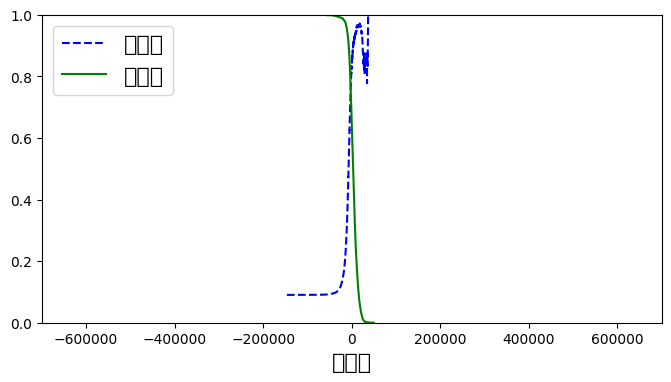

In [32]:
# 임곗값의 함수로 정밀도, 재현율 그리기

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [35]:
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

> 큰 임곗값을 지정하여 가상의 정밀도에 대해 분류기 생성 가능, 하지만 재현율이 너무 낮다면 높은 정밀도의 분류기에서는 유용하지않음

### 3.3.5 ROC 곡선

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

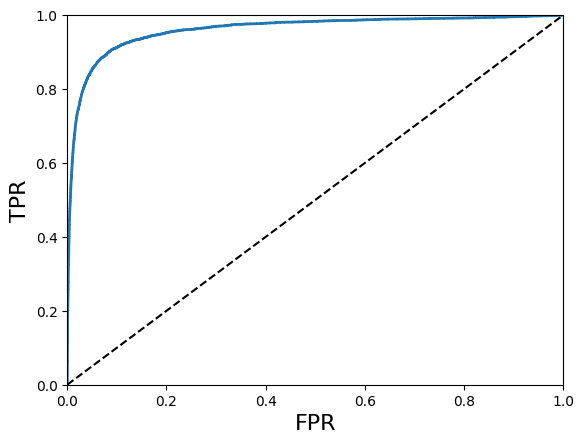

In [44]:
# SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

> 트레이드오프 존재, 좋은 분류기는 ROC 곡선에서 최대한 멀리 떨어져있어야함(왼쪽 위 모서리)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### RandomForestClassifier
* 랜덤포레스트 분류기를 훈련시켜 ROC곡선과 ROC AUC 점수 비교

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") #predict_proba: 샘플이 행, 클래스가 열

In [46]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

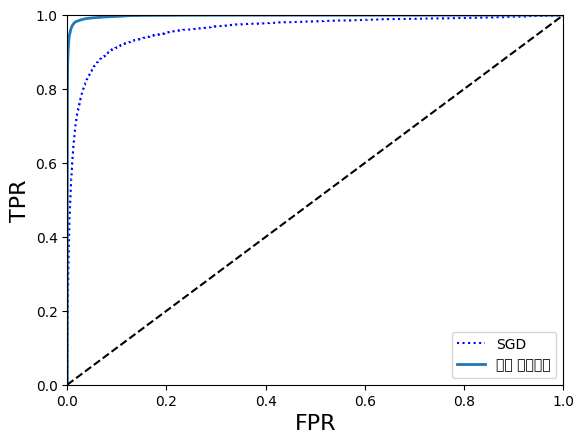

In [47]:
# 첫 번째 ROC 곡선
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

> ROC, ROC AUC 곡선이 더 좋아보임

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

> 정밀도는 99%, 재현율은 86.6%

## 3. 4 다중 분류

둘 이상의 클래스 구별

#### 서포트 벡터 머신 분류기

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5 대신 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

decision_function(): 샘플 당 10개 점수 반환, 클래스 당 하나씩

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

#### OneVsOneClassifier, OneVsRestClassifier

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

#### SGDClassifier, RandomForestClassifier 훈련

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) #3으로 예측

array([3], dtype=uint8)

> SGD는 직접 샘플을 다중 클래스로 분류해서 OvR, OvO 적용 안해도된다.

In [56]:
# SGD가 클래스마다 부여한 점수
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

> 대부분 점수가 큰 음수, 클래스 3만 1823

In [57]:
# 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [58]:
# 스케일 조정하면 정확도 높일 수 있음
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
* 에러 종류를 분석: 가능성이 높은 모델을 찾았다고 가정, 모델 성능 향상시킬 방법

  * 오차 행렬 살펴보기

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

그림 저장: confusion_matrix_plot


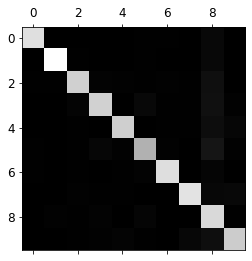

In [ ]:
#이미지로 확인
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 숫자별 총 이미지 개수
norm_conf_mx = conf_mx / row_sums # 숫자별 오차율 행렬

그림 저장: confusion_matrix_errors_plot


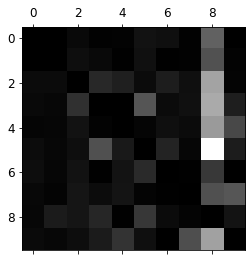

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

그림 저장: error_analysis_digits_plot


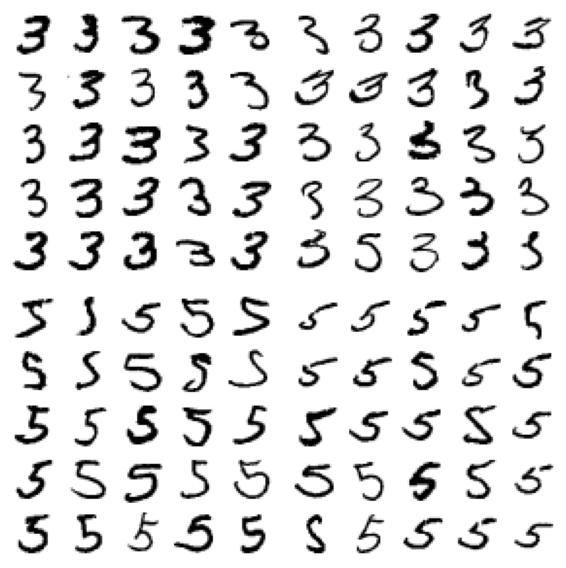

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # 3을 3으로 예측한 샘플들
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # 3을 5로 예측한 샘플들
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # 5를 3으로 예측한 샘플들
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # 5를 5로 예측한 샘플들

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 이미지 상단 왼편
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 이미지 상단 오른편
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 이미지 하단 왼편
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 이미지 하단 오른편
plt.show()

## 3.6 다중 레이블 분류:여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


array([[False,  True]])

In [ ]:
knn_clf.predict([some_digit])

#### 다중 레이블 분류기 평가 방법은 다양
* 지표는 프로젝트에 따라 다름

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

> 위 코드는 모든 레이블의 가중치가 같다고 가정한 것

* 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는 코드 average="weighted"


## 3.7 다중 출력 분류 = 다중 출력 다중 클래스 분류
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있게 일반화 한 것, 값을 두 개 이상 가질 수 있음

### 이미지에서 잡음을 제거하는 시스템
* 잡음 많은 숫자를 이미지 입력으로 받고, 깨끗한 숫자 이미지를 픽셀의 강도를 담은 배열로 출력
* 분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러개 가짐

In [ ]:
# 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

KNeighborsClassifier()